## A. Sample person and cyclist annotations from the annotations
- COCO 2017 train/val dataset (80 classes, 123,287 images, 886,284 instances).
- Read annotations/instances_{train,val}2017.json
- Filter images with [person, bicycle]
- Add a new class label, outer-bounding-box called `cyclist` if `person` & `bicycle` have IoU>20%
- Dump the new annotations to a new file suffixed `cyclist`


## i.) Read, Filter & Export Annotations

### Dataset sampler and YOLOX Detector folder structure
```
Capstone Project
│
└───samples
|   │
|   └───coco_dataset.py
|   └───coco_sampler.ipynb
|   └───proposal.pdf
|
│
└───YOLOX/
    │
    └───tools/train.py
    │
    └───datasets/COCOdataset2017   
        └───images
        │   └───train
        │   │    │   000000000009.jpg
        │   │    │   000000000025.jpg
        │   │    │   ...
        │   └───val   
        │        │   000000000139.jpg
        │        │   000000000285.jpg
        │        │   ...
        └───annotations
            │   instances_train.json
            │   instances_val.json
            |   ...
```

In [1]:
import os
import numpy as np
import pandas as pd

import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from coco_dataset import COCODatasetCustom

In [2]:
COCO_DATA_HOME = "/media/rahul/HIT-GRAID/data/coco"

In [3]:
# List the files in the folder
! ls -lh $COCO_DATA_HOME/annotations/instances*

-rwxrwxrwx 1 rahul rahul 513K Jul 10  2019 /media/rahul/HIT-GRAID/data/coco/annotations/instances_minival2014_100.json
-rwxrwxrwx 1 rahul rahul 449M Sep  1  2017 /media/rahul/HIT-GRAID/data/coco/annotations/instances_train2017.json
-rwxrwxrwx 1 rahul rahul 1.2M Aug  7  2020 /media/rahul/HIT-GRAID/data/coco/annotations/instances_val2017_100.json
-rwxrwxrwx 1 rahul rahul  73M Jul 23  2021 /media/rahul/HIT-GRAID/data/coco/annotations/instances_val2017.json


#### COCO Annotations structure in JSON format

> Extracts from `annotations/instances_*2017.json`
```
{
    "categories": [
        {
            "id": 1,
            "name": "person",
            "supercategory": "person"
        },
        {
            "id": 2,
            "name": "bicycle",
            "supercategory": "vehicle"
        }
    ],
    "images": [
        {
            "id": 0,
            "license": 1,
            "file_name": "<filename0>.<ext>",
            "height": 480,
            "width": 640,
            "date_captured": null
        }
    ],
    "annotations": [
        {
            "id": 0,
            "image_id": 0,
            "category_id": 2,
            "bbox": [ 260, 177, 231, 199 ],
            "segmentation": [ ],
            "area": 45969,
            "iscrowd": 0
        }
    ]
}
```

> We are interested in category `person` and `bicycle`

In [4]:
def export_annotations(ann_type, allowed_list=["person", "bicycle"]):
    ann_file = "instances_{}.json".format(ann_type)
    coco_custom = COCODatasetCustom(data_dir=COCO_DATA_HOME, json_file=ann_file, name=ann_type, selected_categories=allowed_list)   
    coco_custom.export_anns(os.path.join(COCO_DATA_HOME, "annotations", "sampled_{}".format(ann_file)), True)
    return coco_custom

In [5]:
anns_dict = {}
for ann in ["train2017", "val2017"]:
    anns_dict[ann] = export_annotations(ann)

loading annotations into memory...
Done (t=8.93s)
creating index...
index created!
Read annotations for 2643 images from -> /media/rahul/HIT-GRAID/data/coco/annotations/instances_train2017.json
New Annotations: 21797/21797
Export 21797 annotations for 2643 images to -> /media/rahul/HIT-GRAID/data/coco/annotations/sampled_instances_train2017.json
loading annotations into memory...
Done (t=1.43s)
creating index...
index created!
Read annotations for 122 images from -> /media/rahul/HIT-GRAID/data/coco/annotations/instances_val2017.json
New Annotations: 1048/1048
Export 1048 annotations for 122 images to -> /media/rahul/HIT-GRAID/data/coco/annotations/sampled_instances_val2017.json


In [6]:
val2017 = anns_dict["val2017"]

In [7]:
for cat in val2017.cats[0:10]:
    print("Cats: ", cat)

Cats:  {'supercategory': 'person', 'id': 1, 'name': 'person'}
Cats:  {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}
Cats:  {'supercategory': 'person', 'id': 101, 'name': 'cyclist'}


In [8]:
print("Classes: ",val2017._classes)

Classes:  ('person', 'bicycle')


In [9]:
print("Class IDs: ",val2017.class_ids)

Class IDs:  [1, 2]


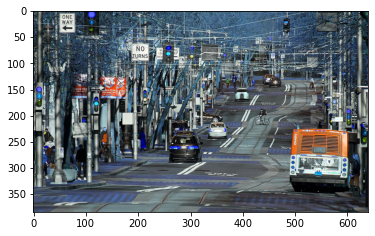

In [10]:
plt.imshow(val2017.load_image(35))

## ii.) New Annotations

In [11]:
def show_ann_type(ann_type, index):
    ann_file = "sampled_instances_{}.json".format(ann_type)
    coco_custom = COCODatasetCustom(data_dir=COCO_DATA_HOME, json_file=ann_file, name=ann_type)   
    print("Number of images (all classes):", len(coco_custom.ids))
    imgids = coco_custom.coco.getImgIds(catIds=[101])
    print("Image Ids for Bicyclist: ",len(imgids))
    plt.imshow(coco_custom.load_image(index))

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Read annotations for 2643 images from -> /media/rahul/HIT-GRAID/data/coco/annotations/sampled_instances_train2017.json
Number of images (all classes): 2643
Image Ids for Bicyclist:  1309


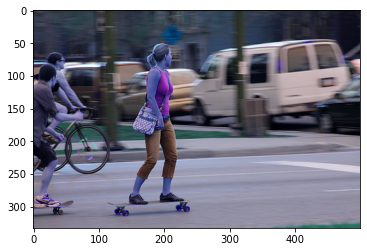

In [12]:
show_ann_type(ann_type="train2017", index = 53)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Read annotations for 122 images from -> /media/rahul/HIT-GRAID/data/coco/annotations/sampled_instances_val2017.json
Number of images (all classes): 122
Image Ids for Bicyclist:  53


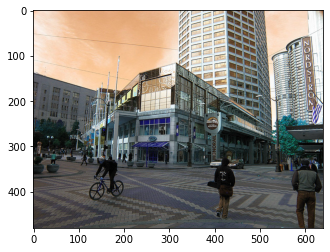

In [13]:
show_ann_type(ann_type="val2017", index = 100)

### iii.) Sampled Dataset creation

In [14]:
TARGET_COCO_DATA_HOME = "./data/cocobi"

In [15]:
import shutil

def copy_ann_images(ann_type):
    ann_file = "sampled_instances_{}.json".format(ann_type)
    coco_custom = COCODatasetCustom(data_dir=COCO_DATA_HOME, json_file=ann_file, name=ann_type)   
    print("Number of images (all classes):", len(coco_custom.ids))
    imgids = coco_custom.coco.getImgIds()
    ims = coco_custom.coco.loadImgs(imgids)
    print("Image Ids for Bicyclist: ", len(ims))
    # copy the annotations
    shutil.copy(os.path.join(COCO_DATA_HOME,"annotations", ann_file), os.path.join(TARGET_COCO_DATA_HOME,"annotations"))
    # copy the image files
    ann_outfolder = os.path.join(TARGET_COCO_DATA_HOME, ann_type)
    for idx, im in enumerate(ims):
        im_filepath = os.path.join(COCO_DATA_HOME, ann_type, im['file_name'])
        #print(idx, "\t", im_filepath) # /media/rahul/HIT-GRAID/data/coco/val2017
        shutil.copy(im_filepath, ann_outfolder)

In [16]:
copy_ann_images(ann_type="val2017")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Read annotations for 122 images from -> /media/rahul/HIT-GRAID/data/coco/annotations/sampled_instances_val2017.json
Number of images (all classes): 122
Image Ids for Bicyclist:  122


In [17]:
copy_ann_images(ann_type="train2017")

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Read annotations for 2643 images from -> /media/rahul/HIT-GRAID/data/coco/annotations/sampled_instances_train2017.json
Number of images (all classes): 2643
Image Ids for Bicyclist:  2643


### iv.) Review new dataset

In [18]:
import os
import numpy as np
import pandas as pd

import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from coco_dataset import COCODatasetCustom

In [19]:
TARGET_COCO_DATA_HOME = "./data/cocobi"

In [20]:
def plot_ann_images(ann_type):
    ann_file = "sampled_instances_{}.json".format(ann_type)
    coco_custom = COCODatasetCustom(data_dir=TARGET_COCO_DATA_HOME, json_file=ann_file, name=ann_type)   
    image_ids = coco_custom.ids
    print("Number of images (all classes):", len(image_ids))
    anno_ids  = coco_custom.coco.getAnnIds(imgIds=image_ids, iscrowd=False)
    annotations = coco_custom.coco.loadAnns(anno_ids)
    count = 0
    labels = []
    for idx, ann in enumerate(annotations):
        labels.append(ann["category_id"])
        if ann["category_id"]>2 and count<5:
            print("\t{}.\t {}".format(idx, ann))
            #print("Image Ids for Bicyclist: ",len(imgids))
            plt.imshow(coco_custom.load_image(idx))
            plt.show()
            count = count+1
    return labels

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Read annotations for 122 images from -> ./data/cocobi/annotations/sampled_instances_val2017.json
Number of images (all classes): 122
	29.	 {'area': 11715.97535, 'bbox': [13.3, 138.39, 148.38, 194.84], 'category_id': 101, 'clean_bbox': [13.3, 138.39, 161.68, 333.23], 'id': 1252497, 'image_id': 343561, 'iscrowd': 0}


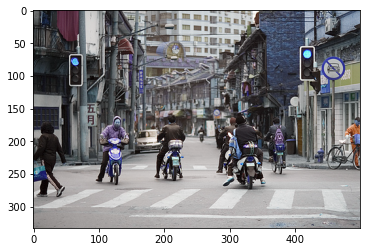

	37.	 {'area': 7956.636649999999, 'bbox': [359.97, 94.92, 99.26, 173.46], 'category_id': 101, 'clean_bbox': [359.97, 94.92, 459.23, 268.38], 'id': 1694507, 'image_id': 343561, 'iscrowd': 0}


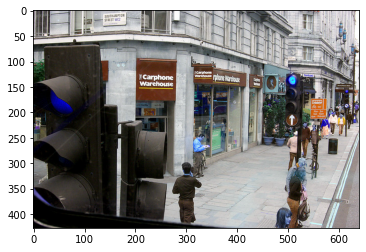

	40.	 {'area': 7920.790000000003, 'bbox': [112.53, 87.52, 92.33, 191.4], 'category_id': 101, 'clean_bbox': [112.53, 87.52, 204.86, 278.92], 'id': 1722503, 'image_id': 343561, 'iscrowd': 0}


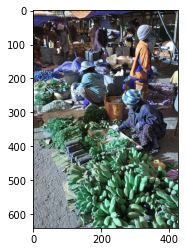

	53.	 {'area': 11798.571450000001, 'bbox': [199.02, 131.99, 134.28, 238.19], 'category_id': 101, 'clean_bbox': [199.02, 131.99, 333.3, 370.18], 'id': 2152271, 'image_id': 343561, 'iscrowd': 0}


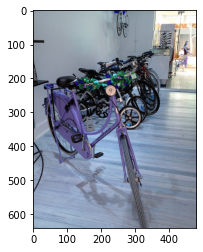

	56.	 {'area': 4253.061950000001, 'bbox': [171.29, 287.02, 74.32, 128.43], 'category_id': 101, 'clean_bbox': [171.29, 287.02, 245.60999999999999, 415.45], 'id': 200190, 'image_id': 169996, 'iscrowd': 0}


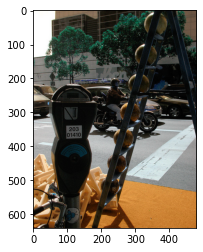

In [21]:
labels = plot_ann_images(ann_type="val2017")

In [22]:
print("Length: ", len(labels))
print("Uniques: ", np.unique(labels))

Length:  1048
Uniques:  [  1   2 101]


(array([706., 273.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         69.]),
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
         23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
         34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
         45.,  46.,  4

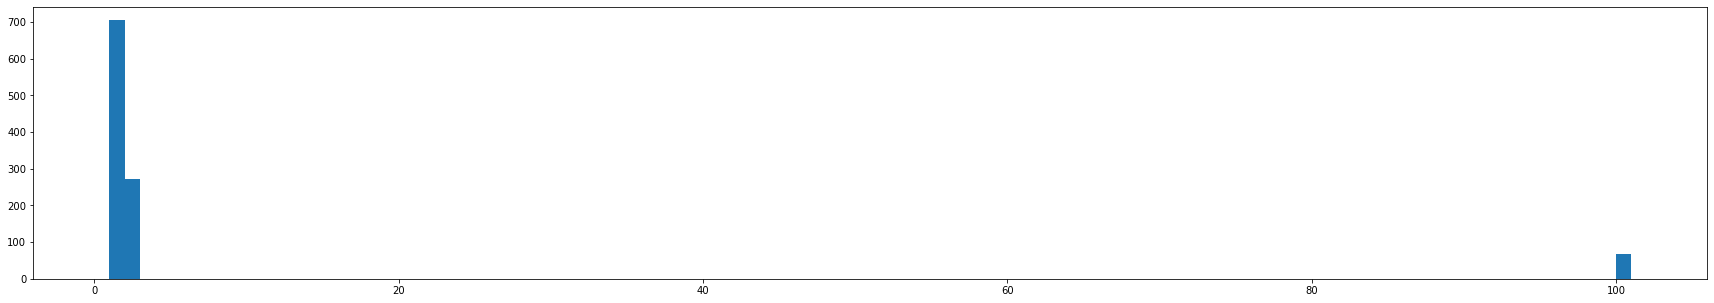

In [23]:
fig, ax = plt.subplots(figsize =(30, 5))
ax.hist(labels, bins=100)